## iimports

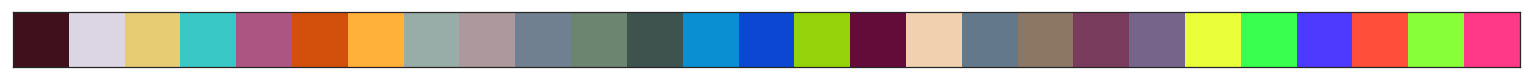

In [1]:
from __future__ import print_function
import matplotlib
import matplotlib.dates as mdates
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sys, os
import io
from typing import Dict, Pattern

import seaborn as sns; sns.set()  # for plot styling
#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a custom palette
PALLET = ['#40111D', '#DCD5E4', '#E7CC74'
                 ,'#39C8C6', '#AC5583', '#D3500C'
                 ,'#FFB139', '#98ADA7', '#AD989E'
                 ,'#708090','#6C8570','#3E534D'

                 ,'#0B8FD3','#0B47D3','#96D30B'                 
                 ,'#630C3A','#F1D0AF','#64788B'                 
                 ,'#8B7764','#7A3C5D','#77648B'
                 ,'#eaff39','#39ff4e','#4e39ff'
                 ,'#ff4e39','#87ff39','#ff3987', ]
N_PALLET = len(PALLET)
sns.set_palette(PALLET)
sns.palplot(PALLET)

In [2]:
%load_ext autoreload
%autoreload 2

#npackages=len(packages.split('\n'))
#type(packages)
#npackages, '\n', packages[0]

In [3]:
# add if you want to add google driveAssertionError
old__file__ = !pwd
__file__ =  old__file__  #!cd ../../NLP ;pwd
#__file__ = !pwd
__file__ = '/gdrive/My Drive'

sys.path.append(__file__)
print(sys.path)
os.chdir(old__file__[0])
!pwd
__file__

['/Users/brucecottman/Documents/PROJECTS/FinMrkt/src', '/usr/local/Cellar/apache-spark/2.0.1/libexec/python', '/Users/brucecottman/Documents/PROJECTS/FinMrkt/src/$', '/Users/brucecottman/anaconda3/lib/python37.zip', '/Users/brucecottman/anaconda3/lib/python3.7', '/Users/brucecottman/anaconda3/lib/python3.7/lib-dynload', '', '/Users/brucecottman/.local/lib/python3.7/site-packages', '/Users/brucecottman/anaconda3/lib/python3.7/site-packages', '/Users/brucecottman/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/brucecottman/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/brucecottman/.ipython', '/gdrive/My Drive']
/Users/brucecottman/Documents/PROJECTS/FinMrkt/src


'/gdrive/My Drive'

## define future value function

In [4]:
def FV(principle=0, deposit=0, withdrawal=0, return_=0, nperiod=1):
    if ((principle + deposit+ withdrawal) == 0): return(0) 
    if (return_ <= 0): return (principle + deposit+ withdrawal) #default is end of period
    amount = (deposit- withdrawal)
    cumamount =  0
    for n in range(1,nperiod+1):
#        print( 'before cumamount',cumamount)
        cumamount = cumamount + deposit*(1+return_)**n
#        print( 'after cumamount',cumamount)
    return(principle*(1+return_**nperiod) + cumamount)


In [5]:
def return_fit(nperiod: int=1, principle: float =0.0, return_: float=0.0)-> float:
    if ((principle) == 0): return(0) 
    if (return_ <= 0): return (principle) #default is end of period
    return(principle*(1+return_)**nperiod)

## fit

In [6]:
from scipy.optimize import curve_fit

def peb(df, ticker, column_name, nppy, low_bounds, high_bounds,nstd):
    # nppy: number of periods per year
    # low_bounds: [low_priniple, low_yield ]
    # high_bounds: [high_priniple, high_yield ]
    #nstd: number of standard deviation = 2*width of error banner

    xddata = df.index  #dates array for axis
    nper = df.index.size # number of periods
    xdata = np.linspace(1,nper,num=nper).astype(int)
    df['ID'] = xdata
    y_data = df[column_name].to_numpy()

             
    # Compute upper and lower bounds using chosen uncertainty measure: here
    # it is a fraction of the standard deviation of measurements at each
    # time point based on the unbiased sample variance
    popt, pcov = curve_fit(return_fit, xdata, y_data, method='trf', 
                           bounds=(low_bounds, high_bounds))
    # determine std of errors
    stderr=np.sqrt(np.diag(pcov))
    yfit_data= return_fit(xdata, *popt)
    # trend line, high error, low error
    df['y_fit'] = yfit_data
    yfit_data_low =  return_fit(xdata, *(popt-stderr*nstd))
    df['y_fit_low'] = yfit_data_low
    yfit_data_high = return_fit(xdata, *(popt+stderr*nstd))
    df['y_fit_high'] = yfit_data_high


    sns.set(rc={'figure.figsize':(12, 6)})
    fig, ax = plt.subplots(figsize=(12,6))
    fig.autofmt_xdate(rotation=45)
    #
    ntm = 19
    interv = nper//ntm  # interval between 25 tick marks
    if interv < 1: interv = 1
        # weekly instead of yearly x axis labels
    if (nppy == 52): 
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=interv))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
#    monthly instead of yearly x axis labels
    elif (nppy == 12): 
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interv))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    # We change the fontsize of minor ticks label 
    
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    # plot raw data
    ax.plot(xddata, y_data, color='black', label='yield')
    # plot fitted yield trend line
    ax.plot(xddata, yfit_data, color='tab:blue', label='yield fit')
    # plot fitted yield lowabs error trend line
    ax.plot(xddata, yfit_data_low, color='tab:blue', alpha=0.1)
    # plot fitted yield high error trend line
    ax.plot(xddata, yfit_data_high, color='tab:blue', alpha=0.1)
    # plot error band
    ax.fill_between(xddata, yfit_data_low, yfit_data_high, alpha=0.2)
    ax.set_ylabel('price($)',size=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ###  Annotate
    astr = "TICKER= {:}\n PRINCIPAL= ${:.2f} \nRETURN= {:.2%}/year".format(ticker, popt[0], popt[1]*nppy) 
    ax.annotate(
        astr,
        xy=(0.5, 0.7), xycoords=ax.transAxes,
        xytext=(-60, 18), textcoords='offset points',
        size=20,
        bbox=dict(boxstyle="round4,pad=.5", fc="0.8"),)

    plt.show()


## read

In [7]:
#!pip install pandas_datareader #if not already installed 

In [14]:
from pandas_datareader.data import DataReader

import copy

import plotly.express as px

In [18]:
start_date = '1900/01/01' 
end_date = '2022/04/25'
ticker = '^IXIC'
EFT_df = DataReader(ticker, 'yahoo', start = start_date, end = end_date)
EFT_df.index = pd.to_datetime(EFT_df.index, format ='%Y-%m-%d')
EFT_df.columns,EFT_df.head(),EFT_df.tail(),EFT_df.size

(Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object'),
                   High         Low        Open       Close  Volume   Adj Close
 Date                                                                          
 1971-02-05  100.000000  100.000000  100.000000  100.000000       0  100.000000
 1971-02-08  100.839996  100.839996  100.839996  100.839996       0  100.839996
 1971-02-09  100.760002  100.760002  100.760002  100.760002       0  100.760002
 1971-02-10  100.690002  100.690002  100.690002  100.690002       0  100.690002
 1971-02-11  101.449997  101.449997  101.449997  101.449997       0  101.449997,
                     High           Low          Open         Close  \
 Date                                                                 
 2022-04-19  13643.969727  13281.219727  13312.440430  13619.660156   
 2022-04-20  13678.549805  13426.129883  13665.379883  13453.070312   
 2022-04-21  13710.700195  13140.830078  13623.700195  13174.650391   
 20

In [16]:
def ticket_read(start_date, end_date, ticker):
    # GET PRICE DATA
    EFT_df = DataReader(ticker, 'yahoo', start = start_date, end = end_date)
    EFT_df.index = pd.to_datetime(EFT_df.index, format ='%Y-%m-%d')
    # determine nummber of peruods per year from 
    delta_days = (EFT_df.index[1] - EFT_df.index[0]).days
    if delta_days > 365:
        nppy = 1
    elif delta_days > 27:
            nppy = 52
    else:
        nppy = 365
    # BIND OTHER VARIABLES
    column_name =  'Adj Close'
    lp = EFT_df[column_name][0]
    hp = 1.1*lp
    ly =0.05
    hy = 0.50

    low_bounds = [lp,ly/nppy]
    high_bounds = [hp, hy/nppy]
    nstd = 3
    peb(EFT_df, ticker, column_name, nppy, low_bounds, high_bounds, nstd)


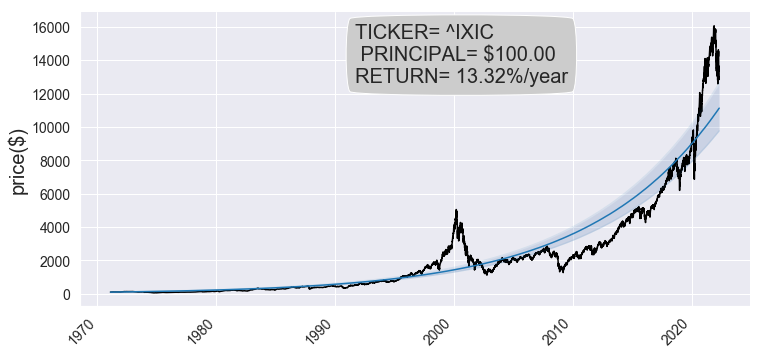

In [19]:
start_date = '1900/01/01' 
end_date = '2022/04/25'
ticker = '^IXIC'
ticket_read(start_date, end_date, ticker)

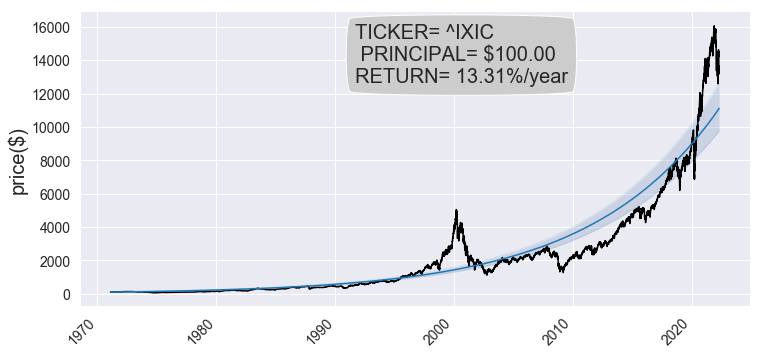

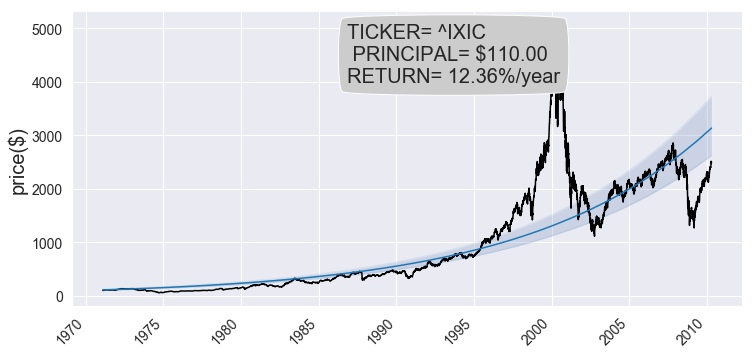

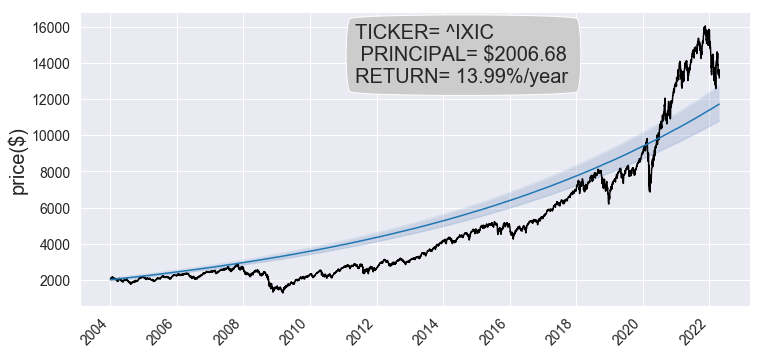

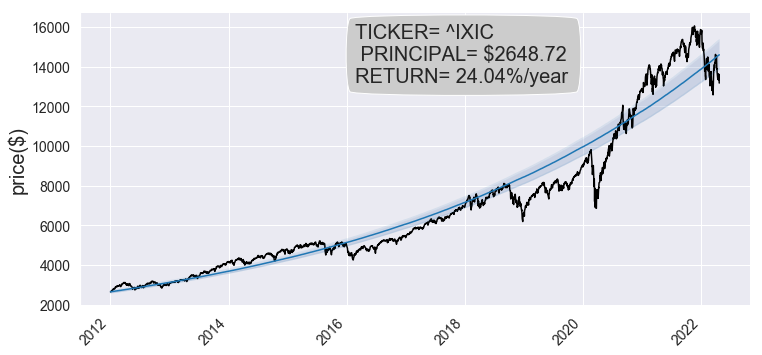

In [21]:
tickers = '^IXIC'
#Image 1 - the full period range
start_date = '1971/02/05' 
end_date = '2022/4/21'
ticket_read(start_date, end_date, ticker)
#Image 2- after 2003 surge # early period
start_date = '1971/02/05' 
end_date = '2010/4/21'
ticket_read(start_date, end_date, ticker)
#Image 3
start_date = '2004/01/01' #late windw
end_date = '2022/4/21'
ticket_read(start_date, end_date, ticker)
#Image 4 - latest bull market
start_date = '2012/01/01' 
end_date = '2022/4/21'
ticket_read(start_date, end_date, ticker)

## 

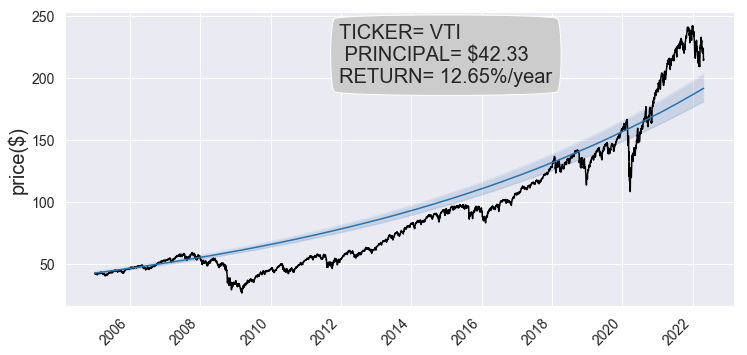

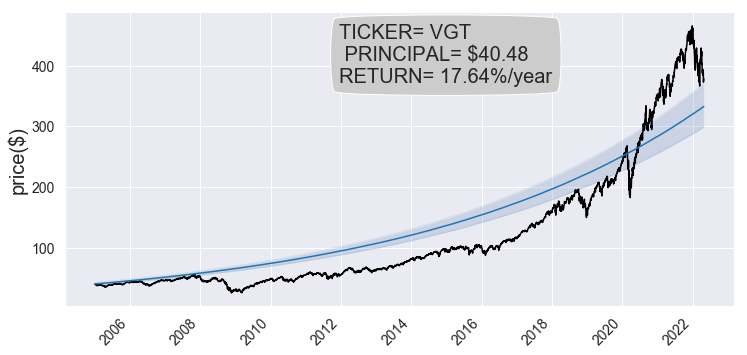

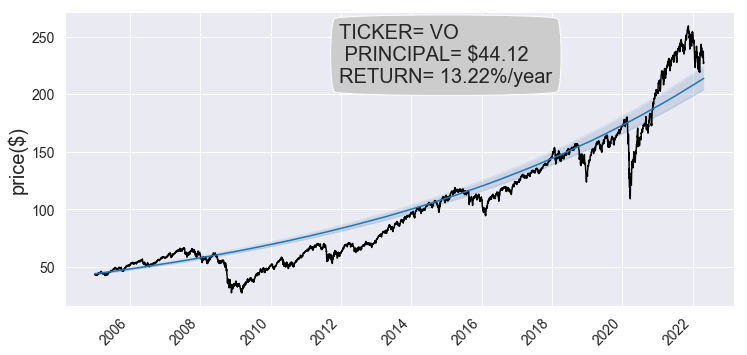

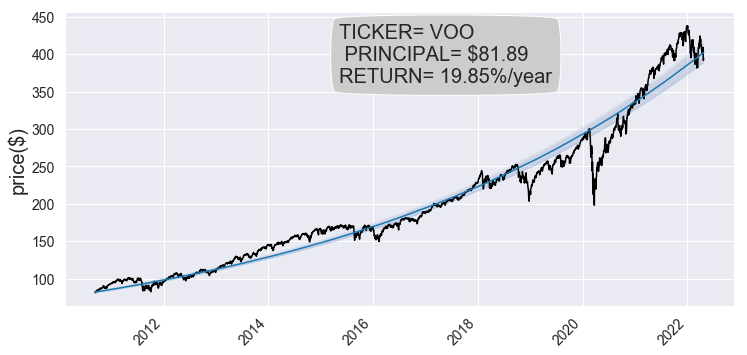

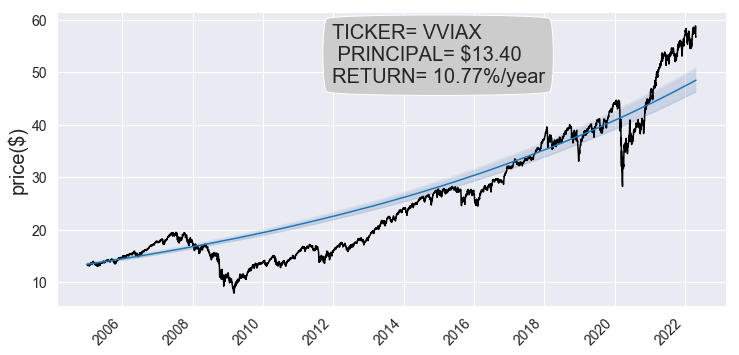

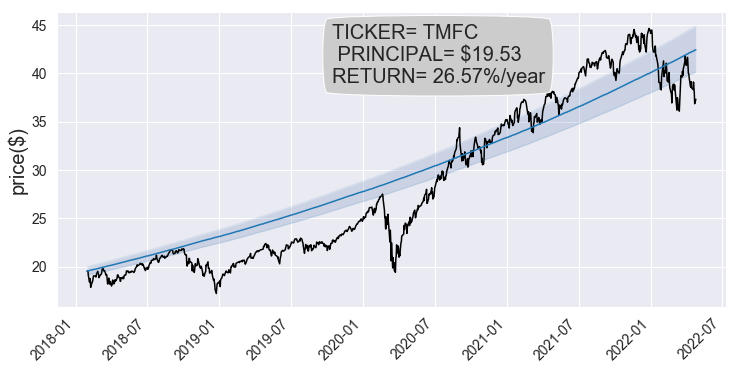

In [17]:
tickers = ['VTI', 'VGT' ,'VO' , 'VOO', 'VVIAX', 'TMFC' ]
for ticker in tickers:
    start_date = '2005/01/01' àa
    end_date = '2022/04/25'

    ticket_read(start_date, end_date, ticker)